In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import numpy as np
from torchvision import datasets
from sklearn.model_selection import train_test_split
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
data_folder = '/kaggle/working/'
fmnist = datasets.FashionMNIST(data_folder, download=True, train=True)
X = fmnist.data
Y = fmnist.targets

100%|██████████| 26421880/26421880 [00:08<00:00, 3290471.84it/s]


Extracting /kaggle/working/FashionMNIST/raw/train-images-idx3-ubyte.gz to /kaggle/working/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 134225.26it/s]


Extracting /kaggle/working/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /kaggle/working/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 2556152.60it/s]


Extracting /kaggle/working/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /kaggle/working/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 10543104.00it/s]

Extracting /kaggle/working/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /kaggle/working/FashionMNIST/raw



In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)

In [4]:
# construtor de dataset para modelo pytorch
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float()/25 # converte pra float e normaliza
        x = x.view(-1, 1, 28, 28) # a dimensão unitária é uma exigência do pytorch, assim como com o tensorflow
        self.x, self.y = x, y
    
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix]
        return x.to(device), y.to(device)
    
    def __len__(self):
        return len(self.x)

In [5]:
from torch.optim import Adam

def get_model():
    model = nn.Sequential(
        nn.Conv2d(1, 64, 3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Conv2d(64, 128, 3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(3200, 256),
        nn.ReLU(),
        nn.Linear(256, 10)
    ).to(device)
    loss_fn = nn.CrossEntropyLoss()
    opt = Adam(model.parameters(), lr = 0.001)
    return model, loss_fn, opt

In [6]:
# função de treino com batch
def train_batch(x, y, model, loss_fn, opt):
    model.train()
    predictions = model(x)
    batch_loss = loss_fn(predictions, y)
    batch_loss.backward()
    opt.step()
    opt.zero_grad()
    return batch_loss.item()

In [7]:
# função de cálculo de precisão
@torch.no_grad()
def accuracy(model, x, y):
    predictions = model(x)
    max_values, argmaxes = predictions.max(-1) # valores máximos e seus índices, que corresponder a classe
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

In [8]:
# função que cria e retorna os dataloaders de treino e teste
def get_data():
    train_ds = FMNISTDataset(X_train, y_train)
    test_ds = FMNISTDataset(X_test, y_test)
    train_dl = DataLoader(train_ds, batch_size = 32, shuffle = True)
    test_dl = DataLoader(test_ds, batch_size = len(train_ds), shuffle = False)
    return train_dl, test_dl

In [9]:
@torch.no_grad()
def val_loss(model, x, y):
    model.eval()
    predictions = model(x)
    val_loss = loss_fn(predictions, y)
    return val_loss.item()

In [10]:
train_dl, test_dl = get_data()
model, loss_fn, opt = get_model()

In [11]:
# loop de treino
train_losses, train_accs = [], []
val_losses, val_accs = [], []
for epoch in range(5):
    print(epoch)
    epoch_train_losses, epoch_train_accs = [], []
    for batch in iter(train_dl):
        x, y = batch
        batch_loss = train_batch(x, y, model, loss_fn, opt)
        epoch_train_losses.append(batch_loss)
    epoch_train_loss = np.array(epoch_train_losses).mean()
    
    for batch in iter(train_dl):
        x, y = batch
        is_correct = accuracy(model, x, y)
        epoch_train_accs.extend(is_correct)
    epoch_train_acc = np.array(epoch_train_accs).mean()
    
    for batch in iter(test_dl):
        x, y = batch
        val_is_correct = accuracy(model, x, y)
        validation_loss = val_loss(model, x, y)
    val_epoch_acc = np.array(val_is_correct).mean()
    
    train_losses.append(epoch_train_loss)
    train_accs.append(epoch_train_acc)
    val_losses.append(validation_loss)
    val_accs.append(val_epoch_acc)
    

0
1
2
3
4


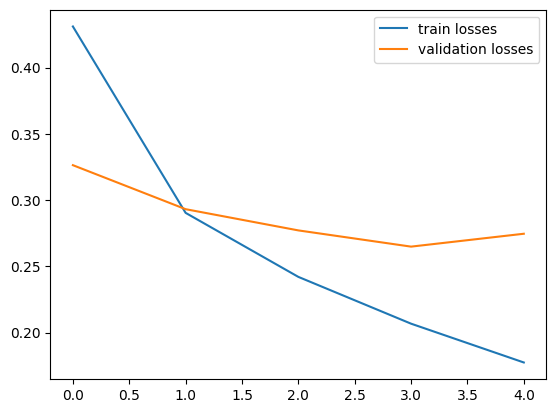

In [12]:
import matplotlib.pyplot as plt
plt.plot(train_losses, label='train losses')
plt.plot(val_losses, label='validation losses')
plt.legend()

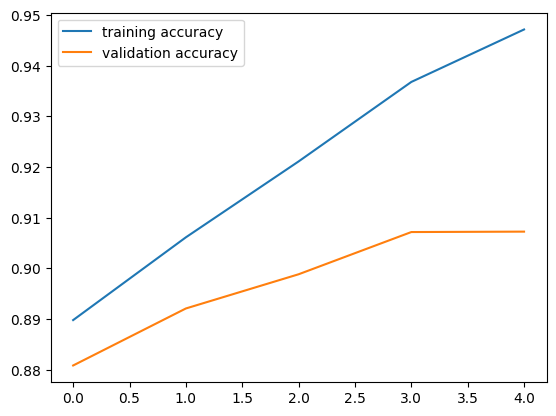

In [13]:
plt.plot(train_accs, label='training accuracy')
plt.plot(val_accs, label = 'validation accuracy')
plt.legend()